# Mask R-CNN - Inspect Vesicle Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
%%time
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.measure import regionprops
import skimage.color

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import datetime
import vesicle

%matplotlib inline 

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


CPU times: user 1.73 s, sys: 389 ms, total: 2.12 s
Wall time: 1.59 s


In [2]:
# Comment out to reload imported modules if they change
# %load_ext autoreload
# %autoreload 2

## Configurations

In [3]:
# Dataset directory
DATASET_DIR = '/allen/programs/braintv/workgroups/neuralcoding/Parastoo'

# Inference Configuration
config = vesicle.VesicleInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1000
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

## Load Validation Dataset

In [6]:
# Load validation dataset
dataset = vesicle.VesicleDataset()
dataset.load_vesicle(DATASET_DIR, "threeD_test")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 48
Classes: ['BG', 'vesicles', 'mitochondria']


## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [8]:
# Path to a specific weights file

weights_path ='/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/vesicles/logs/vesicle20210215T1012/mask_rcnn_vesicle_0079.h5'
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/vesicles/logs/vesicle20210215T1012/mask_rcnn_vesicle_0079.h5







2021-09-03 15:10:08.104370: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-09-03 15:10:08.127703: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3392200000 Hz
2021-09-03 15:10:08.128274: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e377462040 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-09-03 15:10:08.128305: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-09-03 15:10:08.130178: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-03 15:10:08.130197: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-03 15:10:08.130216


Re-starting from epoch 79


## Run Detection

image ID: vesicle.250_006 (6) 250_006
Original image shape:  [250 250   3]
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    1.00000  max:  253.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
gt_class_id              shape: (31,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (31, 4)               min:    0.00000  max:  512.00000  int32
gt_mask                  shape: (512, 512, 31)        min:    0.00000  max:    1.00000  bool
AP @0.50:	 0.848
AP @0.55:	 0.848
AP @0.60:	 0.807
AP @0.65:	 0.609
AP @0.70:	 0.553
AP @0.75:	 0.333
AP @0.80:	 0.191
AP @0.85:	 0.072
AP @0.90:	 0.005
AP @0.95:	 0.000
AP @0.50-0.95:	 0.426


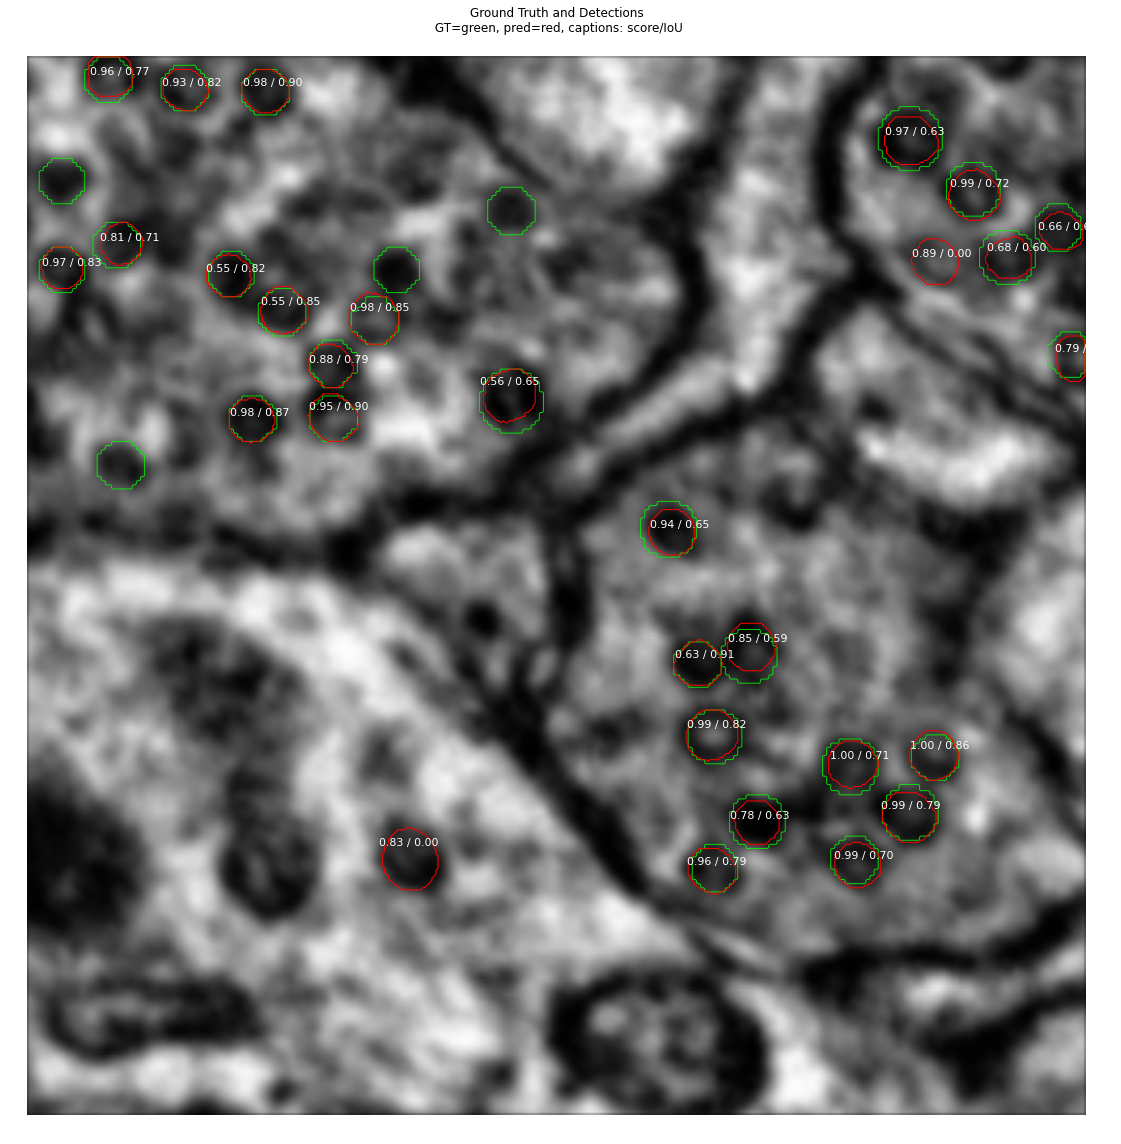

In [9]:
# image_id = random.choice(dataset.image_ids)
image_id = 6
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

image = skimage.color.gray2rgb(image[:, :, 1])
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

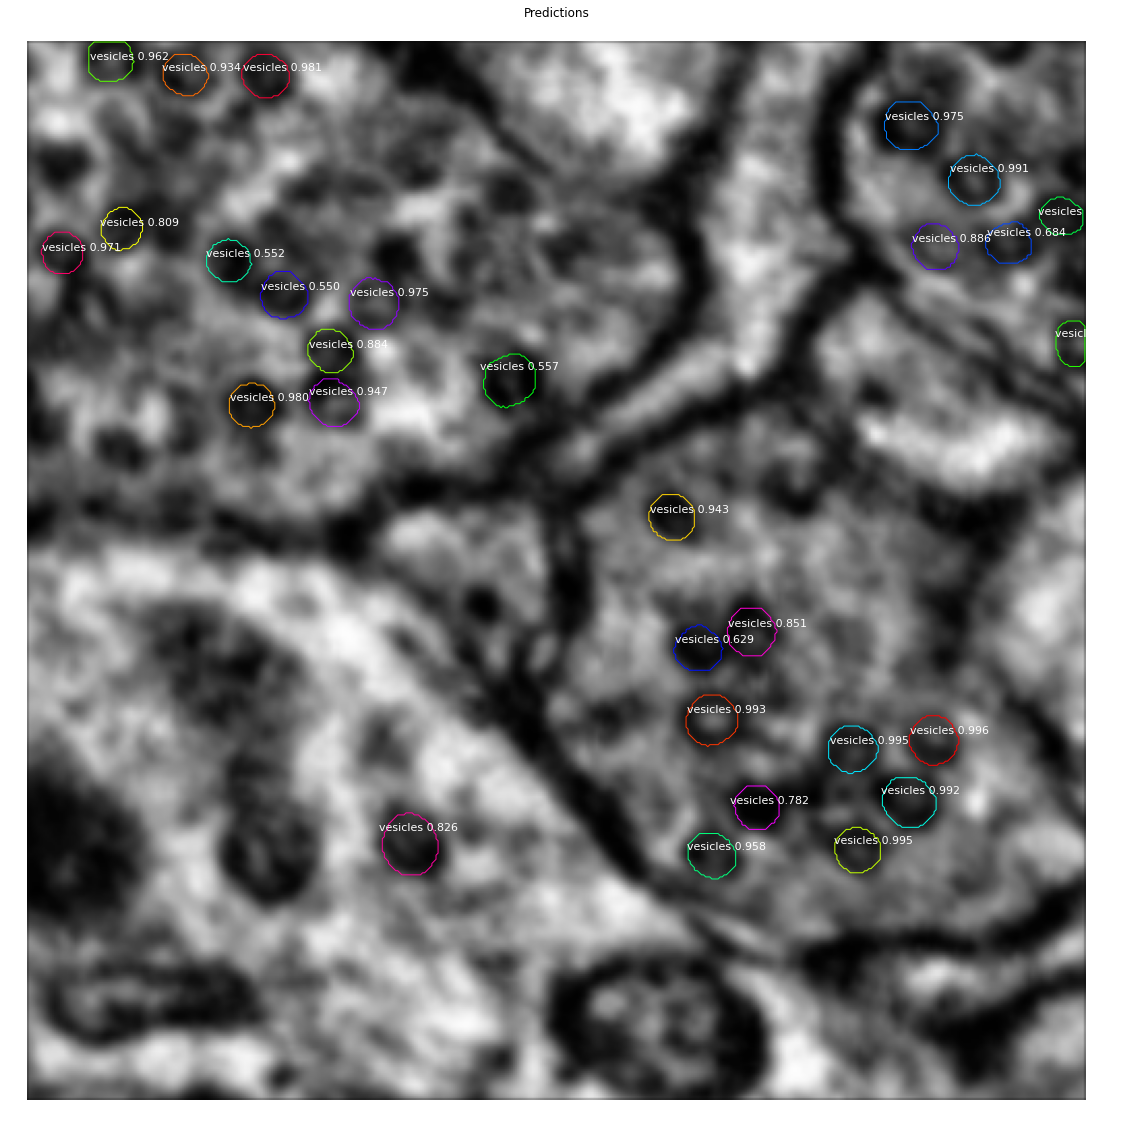

In [10]:
# Display predictions only
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=get_ax(1),
                            show_bbox=False, show_mask=False,
                            title="Predictions")

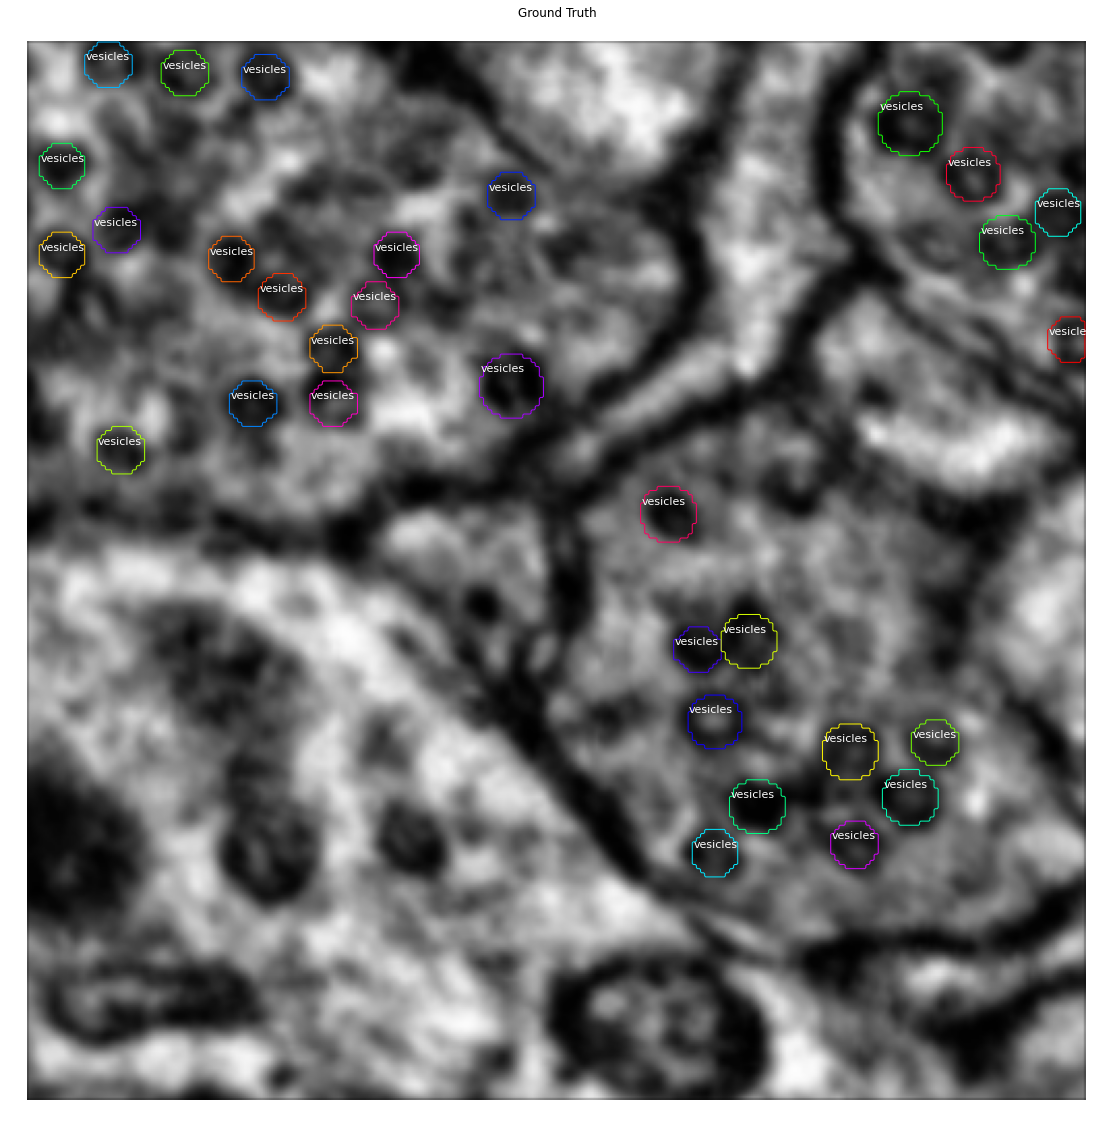

In [11]:
#  Display Ground Truth only
visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, ax=get_ax(1),
                            show_bbox=False, show_mask=False,
                            title="Ground Truth")

### Compute AP on Batch of Images

In [12]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 5

APs = compute_batch_ap(dataset, dataset.image_ids[5:5+limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  5 [250 250   3]   AP: 0.50
  6 [250 250   3]   AP: 0.48
  7 [250 250   3]   AP: 0.45
  8 [250 250   3]   AP: 0.46
  9 [250 250   3]   AP: 0.45
Mean AP overa 5 images: 0.4688


In [13]:
import pandas as pd
model_score_tb = pd.DataFrame(columns = ['image_id', 'scores','class_id','overlaps', 'TP', 'FP'])

In [14]:
val_error=[]
gt_num_ves = 0
for image_id in dataset.image_ids:
    try:
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
        info = dataset.image_info[image_id]

    # Run object detection
        results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

        # Display results
        r = results[0]
        log("gt_class_id", gt_class_id)
        log("gt_bbox", gt_bbox)
        log("gt_mask", gt_mask)

        # Get matches and overlaps
        gt_match, pred_match, overlaps = utils.compute_matches(
            gt_bbox, gt_class_id, gt_mask,
            r["rois"], r["class_ids"], r["scores"], r['masks'],
            iou_threshold=0.5)
        gt_num_ves += len(gt_match)

    #create model score table

        for i in range(len(pred_match)):
            model_score_tb.loc[len(model_score_tb), ['image_id', 'scores', 'class_id', 'overlaps', 'TP']] = dataset.image_info[image_id]['id'], r['scores'][i], r['class_ids'][i], np.max(overlaps), pred_match[i]

        # Compute AP over range 0.5 to 0.95 and print it
        utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                               r['rois'], r['class_ids'], r['scores'], r['masks'],
                               verbose=1)
    except ValueError:
        print('Value Error was raised again')
        val_error.append(image_id)

Value Error was raised again
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    1.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
gt_class_id              shape: (10,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (10, 4)               min:    4.00000  max:  500.00000  int32
gt_mask                  shape: (512, 512, 10)        min:    0.00000  max:    1.00000  bool
AP @0.50:	 0.848
AP @0.55:	 0.848
AP @0.60:	 0.848
AP @0.65:	 0.848
AP @0.70:	 0.706
AP @0.75:	 0.514
AP @0.80:	 0.256
AP @0.85:	 0.122
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.499
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  2

### Plot ROC curve

In [15]:
rows = np.where(model_score_tb.class_id == 2)[0]
model_score_tb.drop(index=rows, inplace=True)

In [16]:
model_score_tb.loc[model_score_tb.TP > -1, ['TP', "FP"]] = 1 , 0
model_score_tb.loc[model_score_tb.TP == -1, ['TP', "FP"]] = 0 , 1
sorted_df  = model_score_tb.sort_values('scores', ascending=False)
precisions = np.cumsum(sorted_df.TP.values > 0) / (np.arange(len(sorted_df)) + 1)
precisions = np.concatenate([[0], precisions, [0]])
for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])
        

recalls = np.cumsum(sorted_df.TP.values > 0).astype(np.float32) / gt_num_ves
recalls = np.concatenate([[0], recalls, [1]])

indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
             precisions[indices])

sorted_df['precision'] = precisions[1:-1]
sorted_df['recall'] = recalls[1:-1]

In [17]:
model_score_tb.head(5)

image_id    scores class_id  overlaps TP FP
0  250_001  0.986162        1  0.890777  1  0
1  250_001  0.981739        1  0.890777  1  0
2  250_001  0.975769        1  0.890777  1  0
3  250_001  0.961126        1  0.890777  1  0
4  250_001  0.919749        1  0.890777  1  0

In [75]:
# Average precision recall at 50% overlap
mAP

0.8421798183078719

Text(0.5, 0, 'recall')

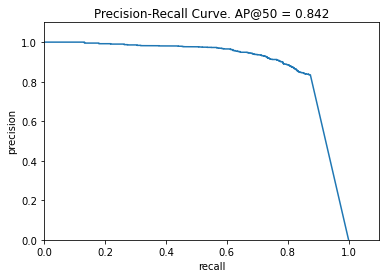

In [19]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [45]:
# Get anchors and convert to pixel coordinates
anchors = model.get_anchors(image.shape)
anchors = utils.denorm_boxes(anchors, image.shape[:2])
log("anchors", anchors)

# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = anchors[positive_anchor_ix]
negative_anchors = anchors[negative_anchor_ix]
neutral_anchors = anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

anchors                  shape: (65472, 4)            min:  -91.00000  max:  539.00000  int32
target_rpn_match         shape: (65472,)              min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (64, 4)               min:   -2.18750  max:    3.25294  float64
positive_anchors         shape: (8, 4)                min:   16.00000  max:  496.00000  int32
negative_anchors         shape: (56, 4)               min:  -11.00000  max:  499.00000  int32
neutral anchors          shape: (65408, 4)            min:  -91.00000  max:  539.00000  int32
refined_anchors          shape: (8, 4)                min:   10.00000  max:  494.00000  float32


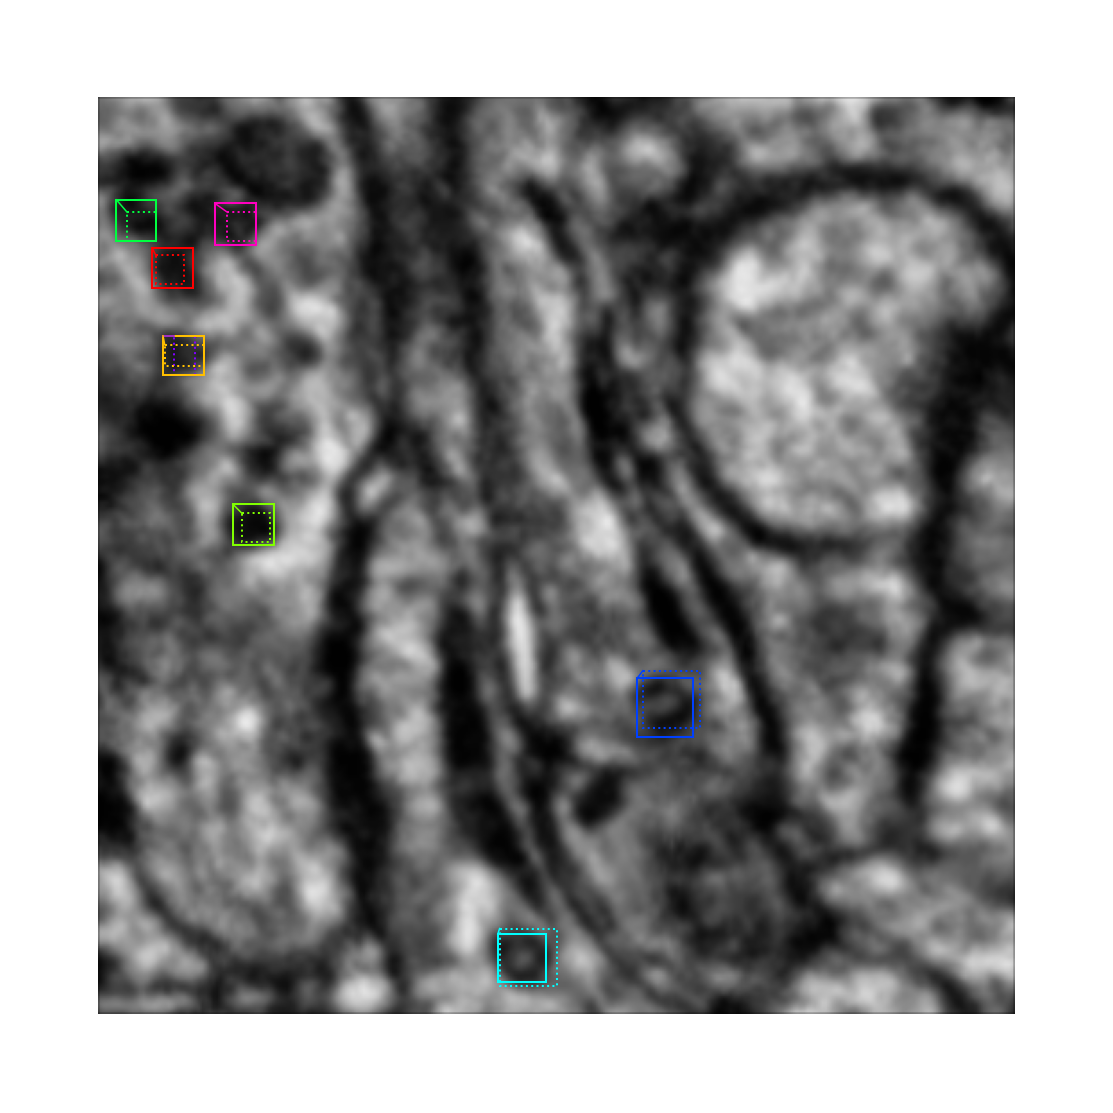

In [47]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
image = skimage.color.gray2rgb(image[:, :, 1])
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=positive_anchors,
    refined_boxes=refined_anchors)

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [48]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph(image[np.newaxis], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
], image_metas=image_meta[np.newaxis])

rpn_class                shape: (1, 65472, 2)         min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.17712  max:    1.05188  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.36199  max:    1.47987  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (2000,)               min:    0.00000  max: 2202.00000  int32
proposals                shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32


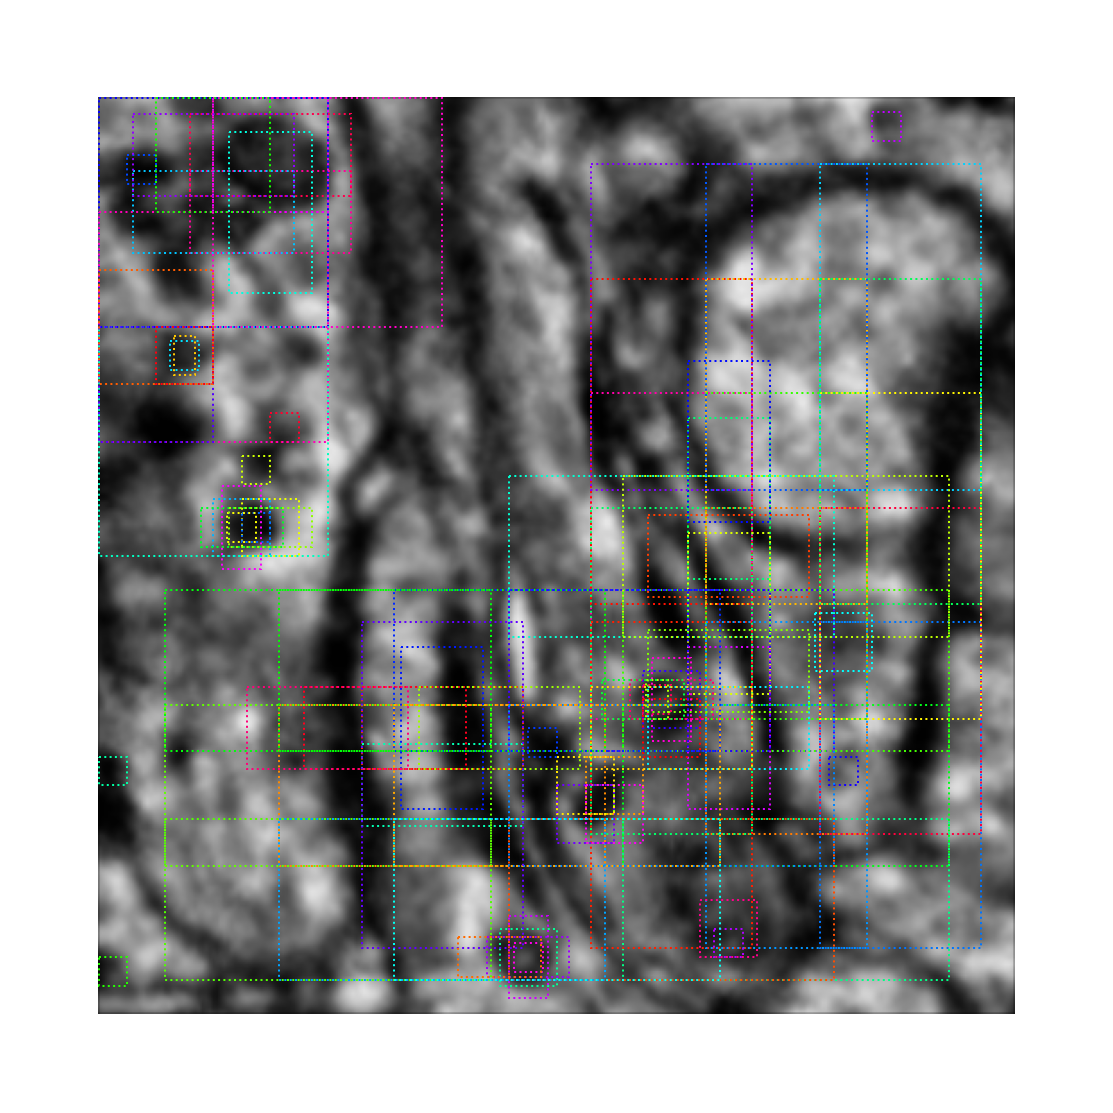

In [49]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=anchors[sorted_anchor_ids[:limit]], ax=get_ax())

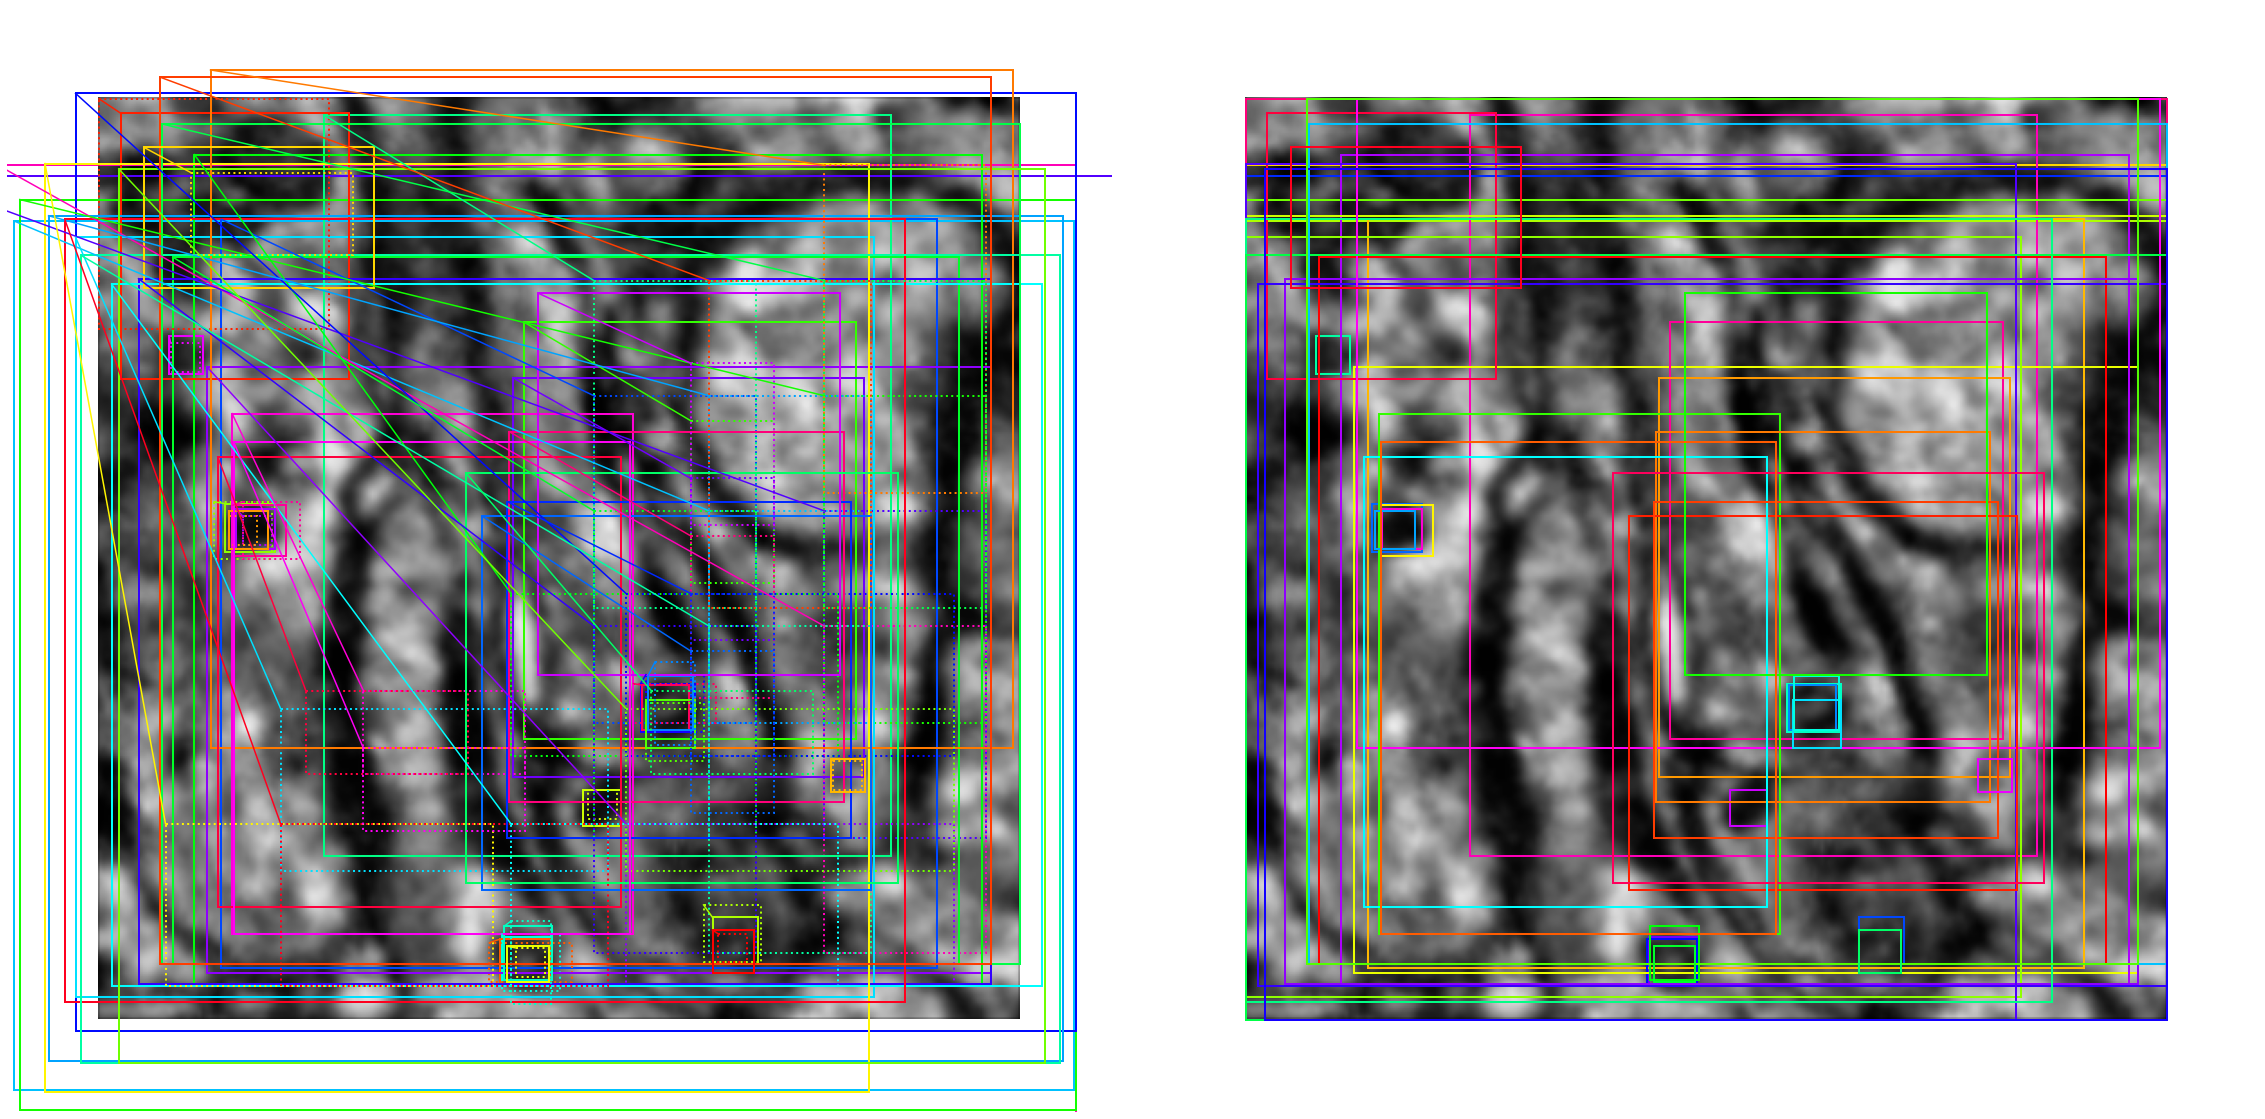

In [51]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

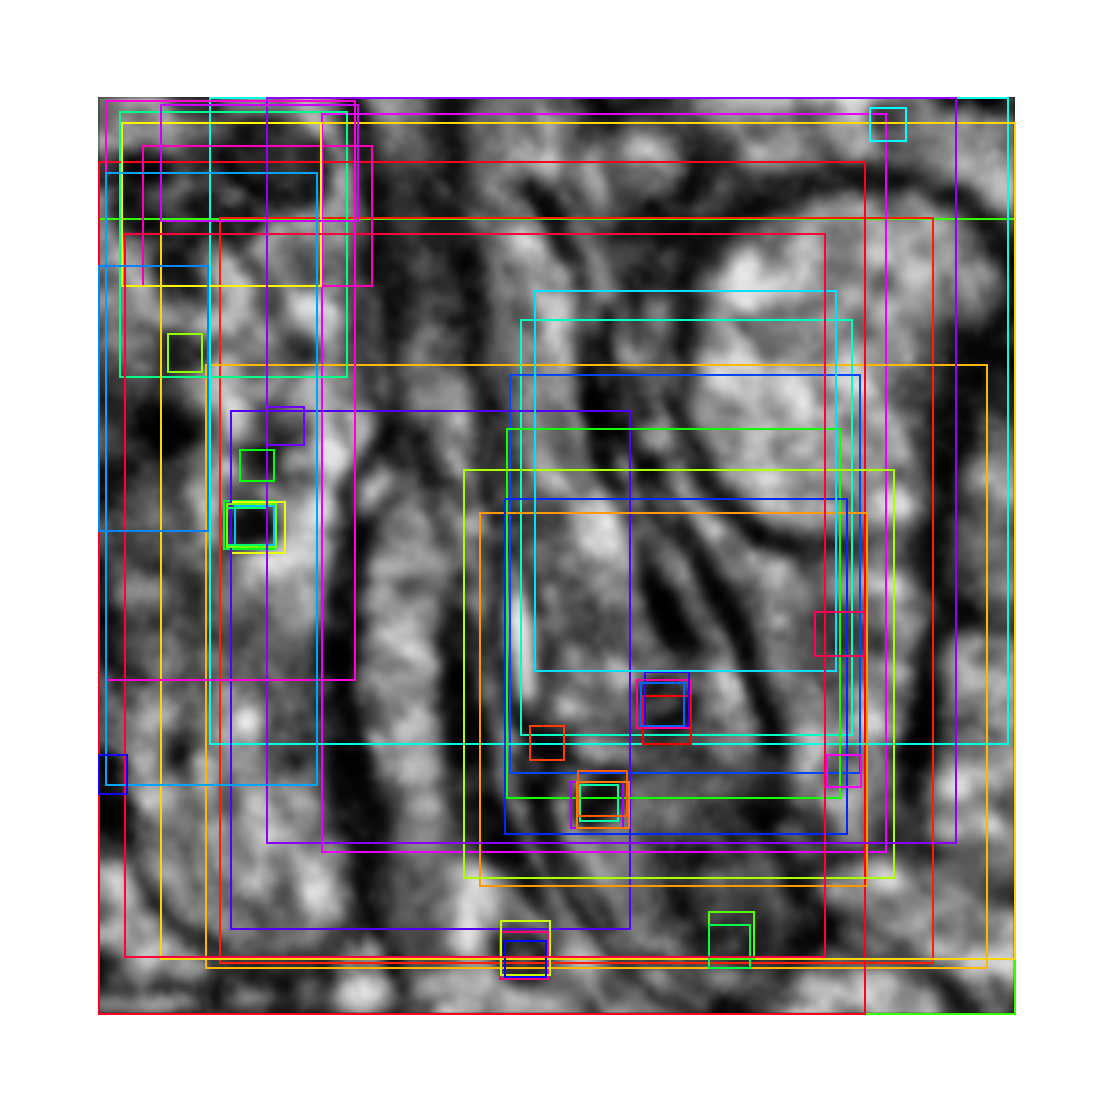

In [52]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

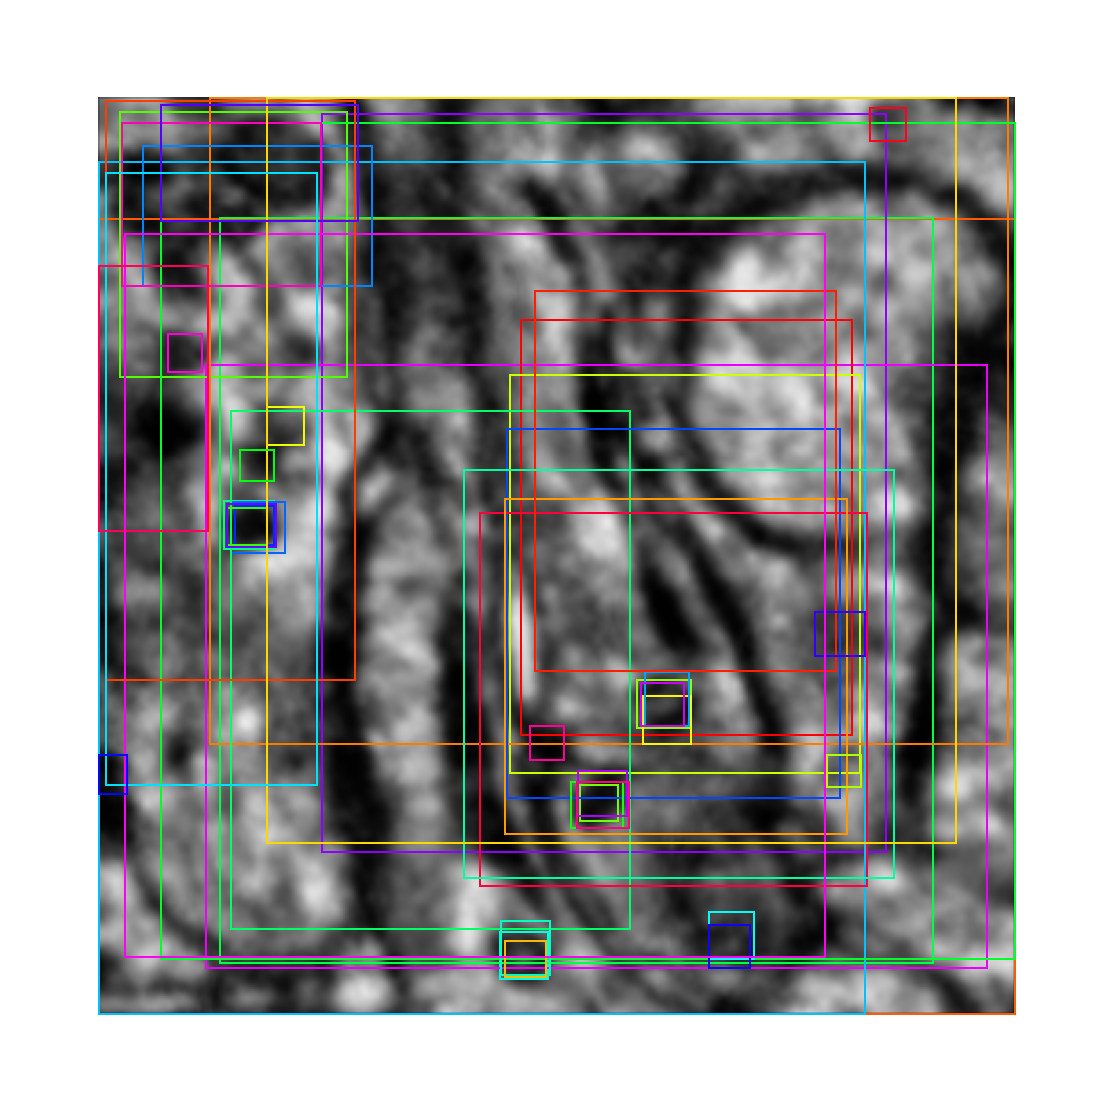

In [53]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
# h, w = config.IMAGE_SHAPE[:2]
# proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(
    image, ax=get_ax(),
    refined_boxes=utils.denorm_boxes(rpn['proposals'][0, :limit], image.shape[:2]))

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [54]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 2000, 3)          min:    0.00000  max:    0.99996  float32
deltas                   shape: (1, 2000, 3, 4)       min:   -2.64133  max:    2.75052  float32
masks                    shape: (1, 1000, 28, 28, 3)  min:    0.00145  max:    0.99999  float32
detections               shape: (1, 1000, 6)          min:    0.00000  max:    2.00000  float32


### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [65]:
# Proposals are in normalized coordinates
proposals = mrcnn["proposals"][0]

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

2000 Valid proposals out of 2000
14 Positive ROIs
[('BG', 1986), ('mitochondria', 14)]


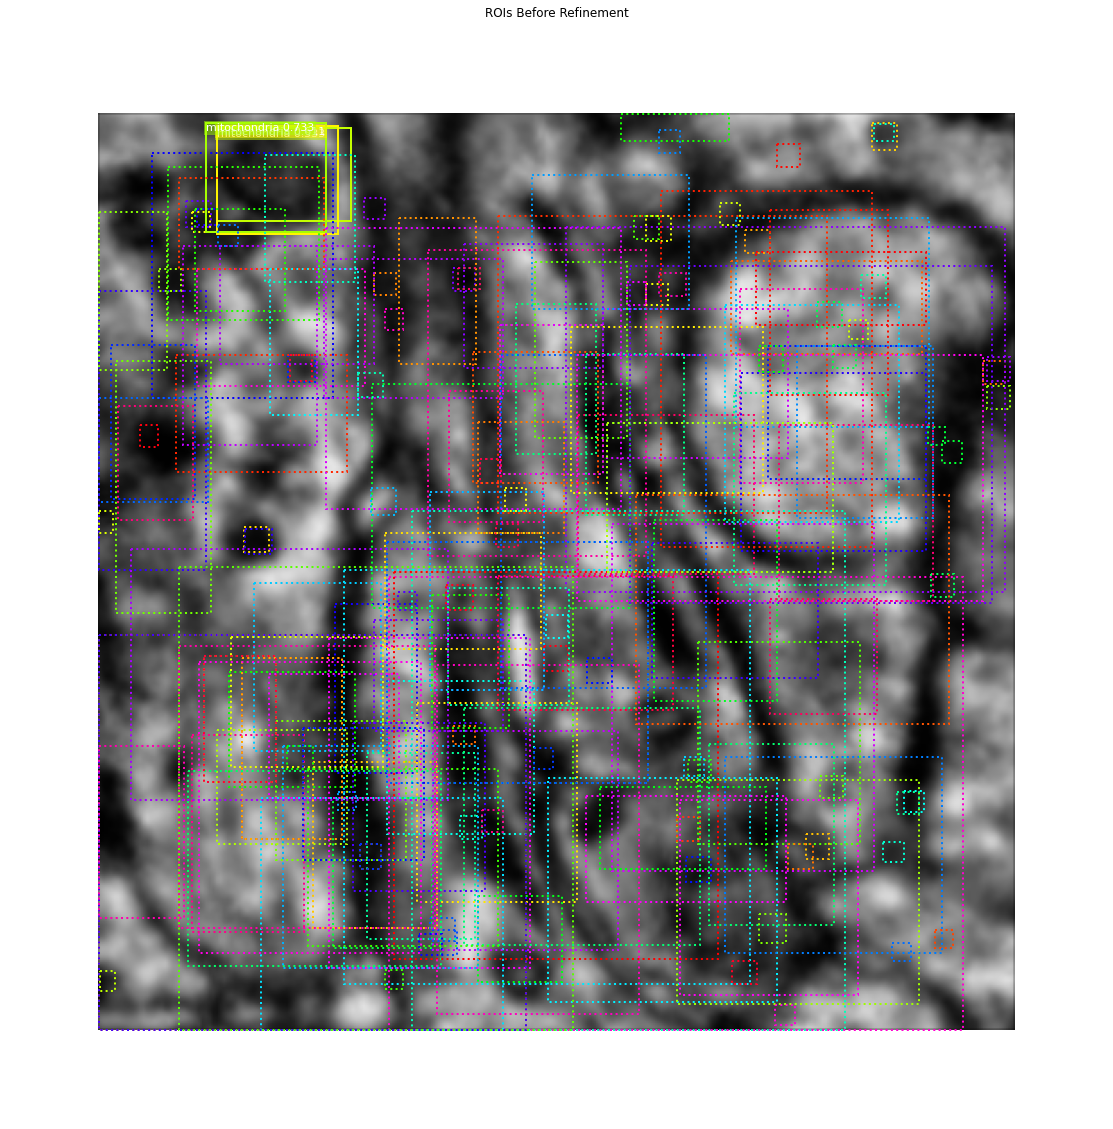

In [66]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
    captions=captions, title="ROIs Before Refinement",
    ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (2000, 4)             min:   -2.64133  max:    2.43746  float32
refined_proposals        shape: (2000, 4)             min:   -0.07199  max:    1.04947  float32


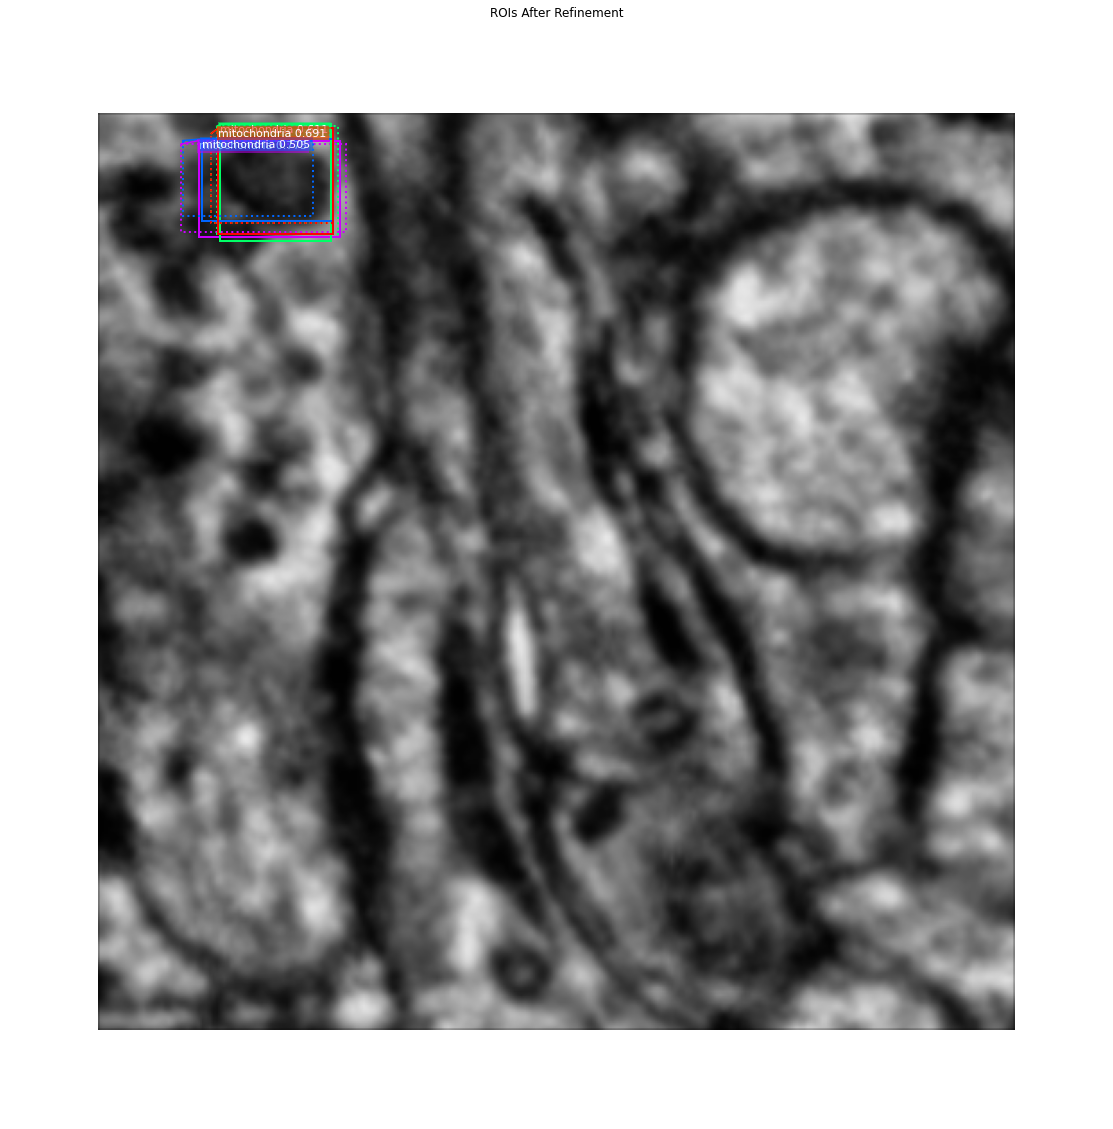

In [67]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=utils.denorm_boxes(proposals[roi_positive_ixs][ids], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[roi_positive_ixs][ids], image.shape[:2]),
    visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
    captions=captions, title="ROIs After Refinement")

#### Filter Low Confidence Detections

In [68]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 14 detections:
[   9   31   43   81   83  124  133  137  171  179  359  402 1430 1896]


In [69]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0 confidence. Keep 14:
[   9   31   43   81   83  124  133  137  171  179  359  402 1430 1896]


#### Per-Class Non-Max Suppression

In [70]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

mitochondria          : [   9   31   43   81   83  124  133  137  171  179  359  402 1430 1896] -> [179]

Kept after per-class NMS: 1
[179]


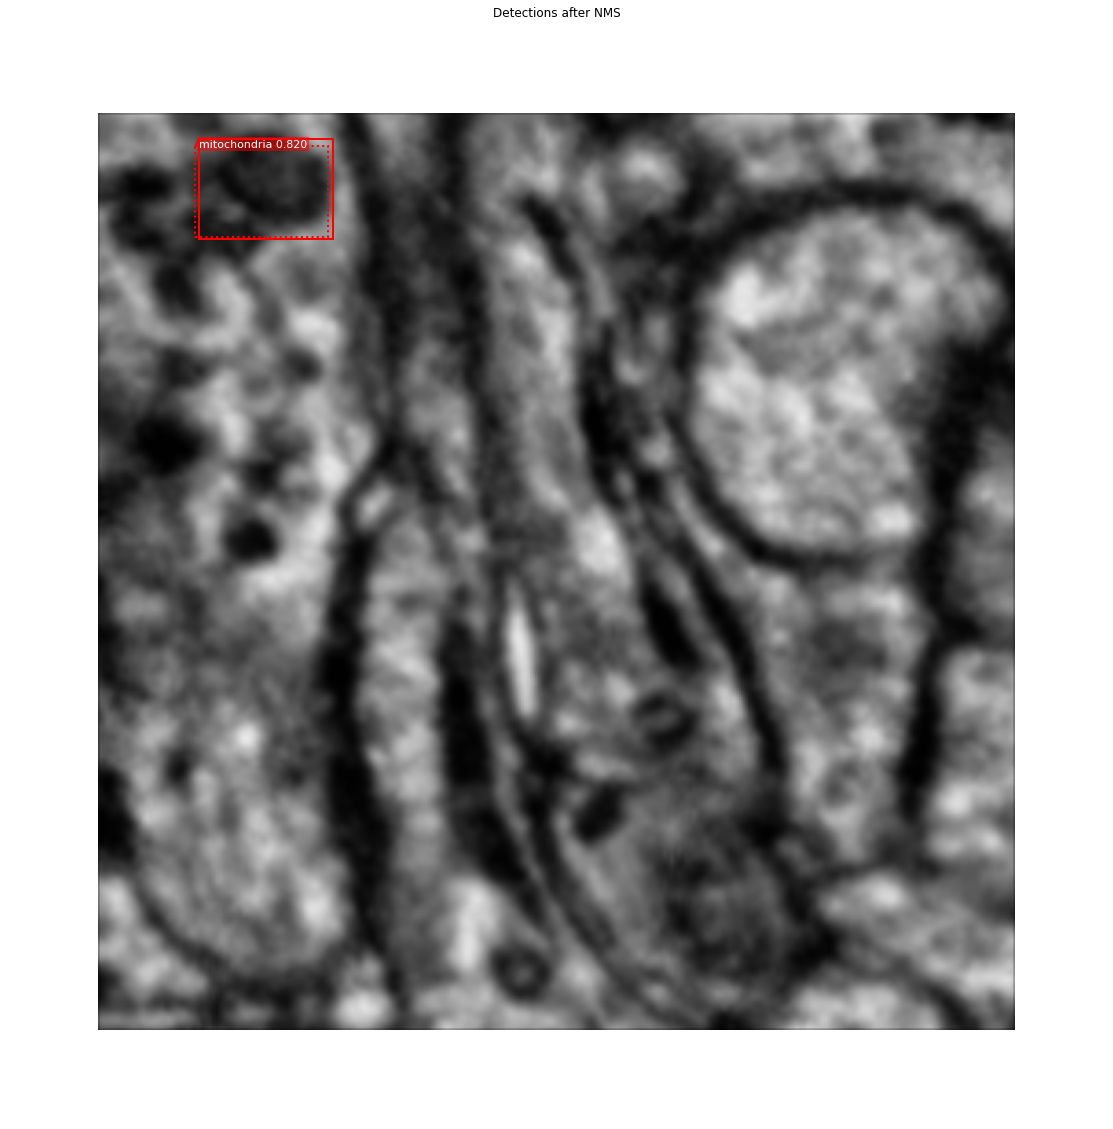

In [71]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[keep][ixs], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[keep][ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

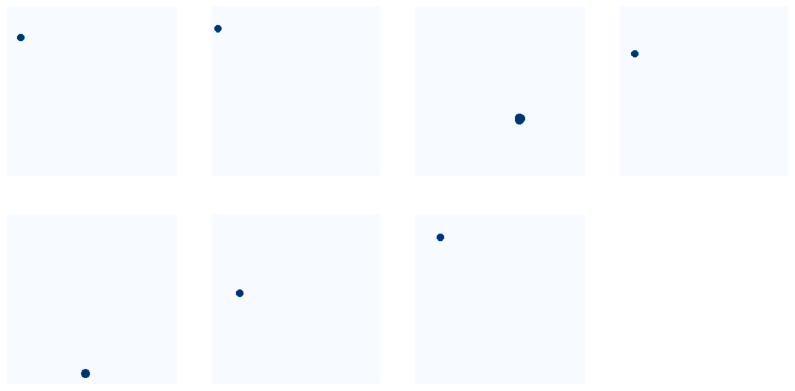

In [72]:
limit = 8
display_images(np.transpose(gt_mask[..., :limit], [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [73]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 1000, 6)          min:    0.00000  max:    2.00000  float32
masks                    shape: (1, 1000, 28, 28, 3)  min:    0.00145  max:    0.99999  float32
1 detections: ['mitochondria']


In [38]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (1, 28, 28)           min:    0.03765  max:    1.00000  float32
det_masks                shape: (1, 512, 512)         min:    0.00000  max:    1.00000  bool


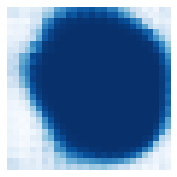

In [39]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

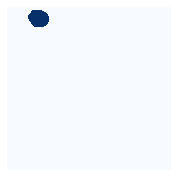

In [40]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")